In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

## Import data

In [2]:
file_path = "stem_results.xlsx"

In [3]:
sps1_emissions = "SPS1 - emissions"
sps1_sources = "SPS1 - e generation"

In [4]:
df_sps1_emissions = pd.read_excel(file_path, sheet_name=sps1_emissions)
df_sps1_sources = pd.read_excel(file_path, sheet_name=sps1_sources)

## Apply cut off for 'Other'

In [5]:
def apply_cutoff(df, cut_off):
    # Create a new DataFrame to store the categorized data
    df_categorized = df.copy()

    # Initialize an "Other" row if it doesn't exist
    if "Other" not in df_categorized["Sector"].values:
        other_row = pd.DataFrame({
            "SPS": [df["SPS"].iloc[0]],
            "Region": [df["Region"].iloc[0]],
            "Sector": ["Other"],
            "unit": [df["unit"].iloc[0]]
        })
        for col in df.columns[4:]:
            other_row[col] = 0
        df_categorized = pd.concat([df_categorized, other_row], ignore_index=True)

    # Loop over each year column to categorize variables
    for year in df.columns[4:]:
        total = df[year].sum()
        percentages = df[year].abs() / total

        # Identify variables that fall under the "Other" category
        other_sum = 0
        for i, percentage in percentages.items():
            if percentage < cut_off and df.at[i, year] >= 0:
                other_sum += df.at[i, year]
                df_categorized.at[i, year] = 0

        # # Debugging information
        # print(f"Year: {year}")
        # print(f"Total: {total}")
        # print(f"Percentages:\n{percentages}")
        # print(f"Other sum for year {year}: {other_sum}")

        # Update the "Other" row
        df_categorized.loc[df_categorized["Sector"] == "Other", year] += other_sum

    return df_categorized

In [6]:
cut_off = 0.05  # 5%

In [7]:
df_sps1_emissions_cutoff = apply_cutoff(df_sps1_emissions, cut_off)
df_sps1_sources_cutoff = apply_cutoff(df_sps1_sources, cut_off)

In [8]:
# Remove rows where all values from 2020 to 2050 are zero
df_sps1_emissions_cutoff = df_sps1_emissions_cutoff[(df_sps1_emissions_cutoff.iloc[:, 4:] != 0).any(axis=1)]
df_sps1_sources_cutoff = df_sps1_sources_cutoff[(df_sps1_sources_cutoff.iloc[:, 4:] != 0).any(axis=1)]

In [9]:
df_sps1_emissions_melted = df_sps1_emissions_cutoff.melt(
    id_vars=["SPS", "Region", "Sector", "unit"], 
    var_name="Year", 
    value_name="Value"
)
df_sps1_sources_melted = df_sps1_sources_cutoff.melt(
    id_vars=["SPS", "Region", "Sector", "unit"], 
    var_name="Year", 
    value_name="Value"
)

## Visualization

In [10]:
sector_colors_sources = {
    "Oil (fossil liquids)": "midnightblue",
    "Gas (fossil)": "slateblue",
    "Nuclear": "forestgreen",
    "Wood": "darkgoldenrod",
    "Waste (non renewable)": "saddlebrown",
    "Waste (renewable)": "lightgreen",
    "Hydro": "lightblue",
    "Solar": "gold",
    "Ambient heat": "lightsalmon",
    "Other": "dimgray"
}

sector_colors_emissions = {
    "Industry": "mediumpurple",
    "Other": "dimgray",
    "Power generation": "gold",
    "Residential": "orange",
    "Services": "yellowgreen",
    "Synthetic fuel production": "lightblue",
    "Transport": "firebrick"
}

In [11]:
# Set default font size for all plot elements
plt.rcParams.update({'font.size': 32, 'font.family': 'Verdana'})

In [12]:
def plot_with_consistent_colors(df, ax, title, xlim, sector_colors):
    sectors = df.columns
    color_map = [sector_colors[sector] for sector in sectors]
    df.plot(kind='barh', stacked=True, ax=ax, color=color_map, zorder=3)
    ax.set_title(title, fontsize=32, pad=30)
    ax.set_xlim(xlim)
    ax.grid(True, zorder=0)
    for bar in ax.patches:
        bar.set_edgecolor('gray')
        bar.set_linewidth(0.7)

In [13]:
# Pivot the data to aggregate values per year and sector
df_sources_pivot_sps1 = df_sps1_sources_melted.pivot(index='Year', columns='Sector', values='Value').fillna(0)
df_emissions_pivot_sps1 = df_sps1_emissions_melted.pivot(index='Year', columns='Sector', values='Value').fillna(0)

In [14]:
# Filter data to include only the years 2020, 2030, 2040, and 2050
years_to_plot = [2020, 2030, 2040, 2050]
df_sources_pivot_sps1_filtered = df_sources_pivot_sps1.loc[years_to_plot]
df_emissions_pivot_sps1_filtered = df_emissions_pivot_sps1.loc[years_to_plot]

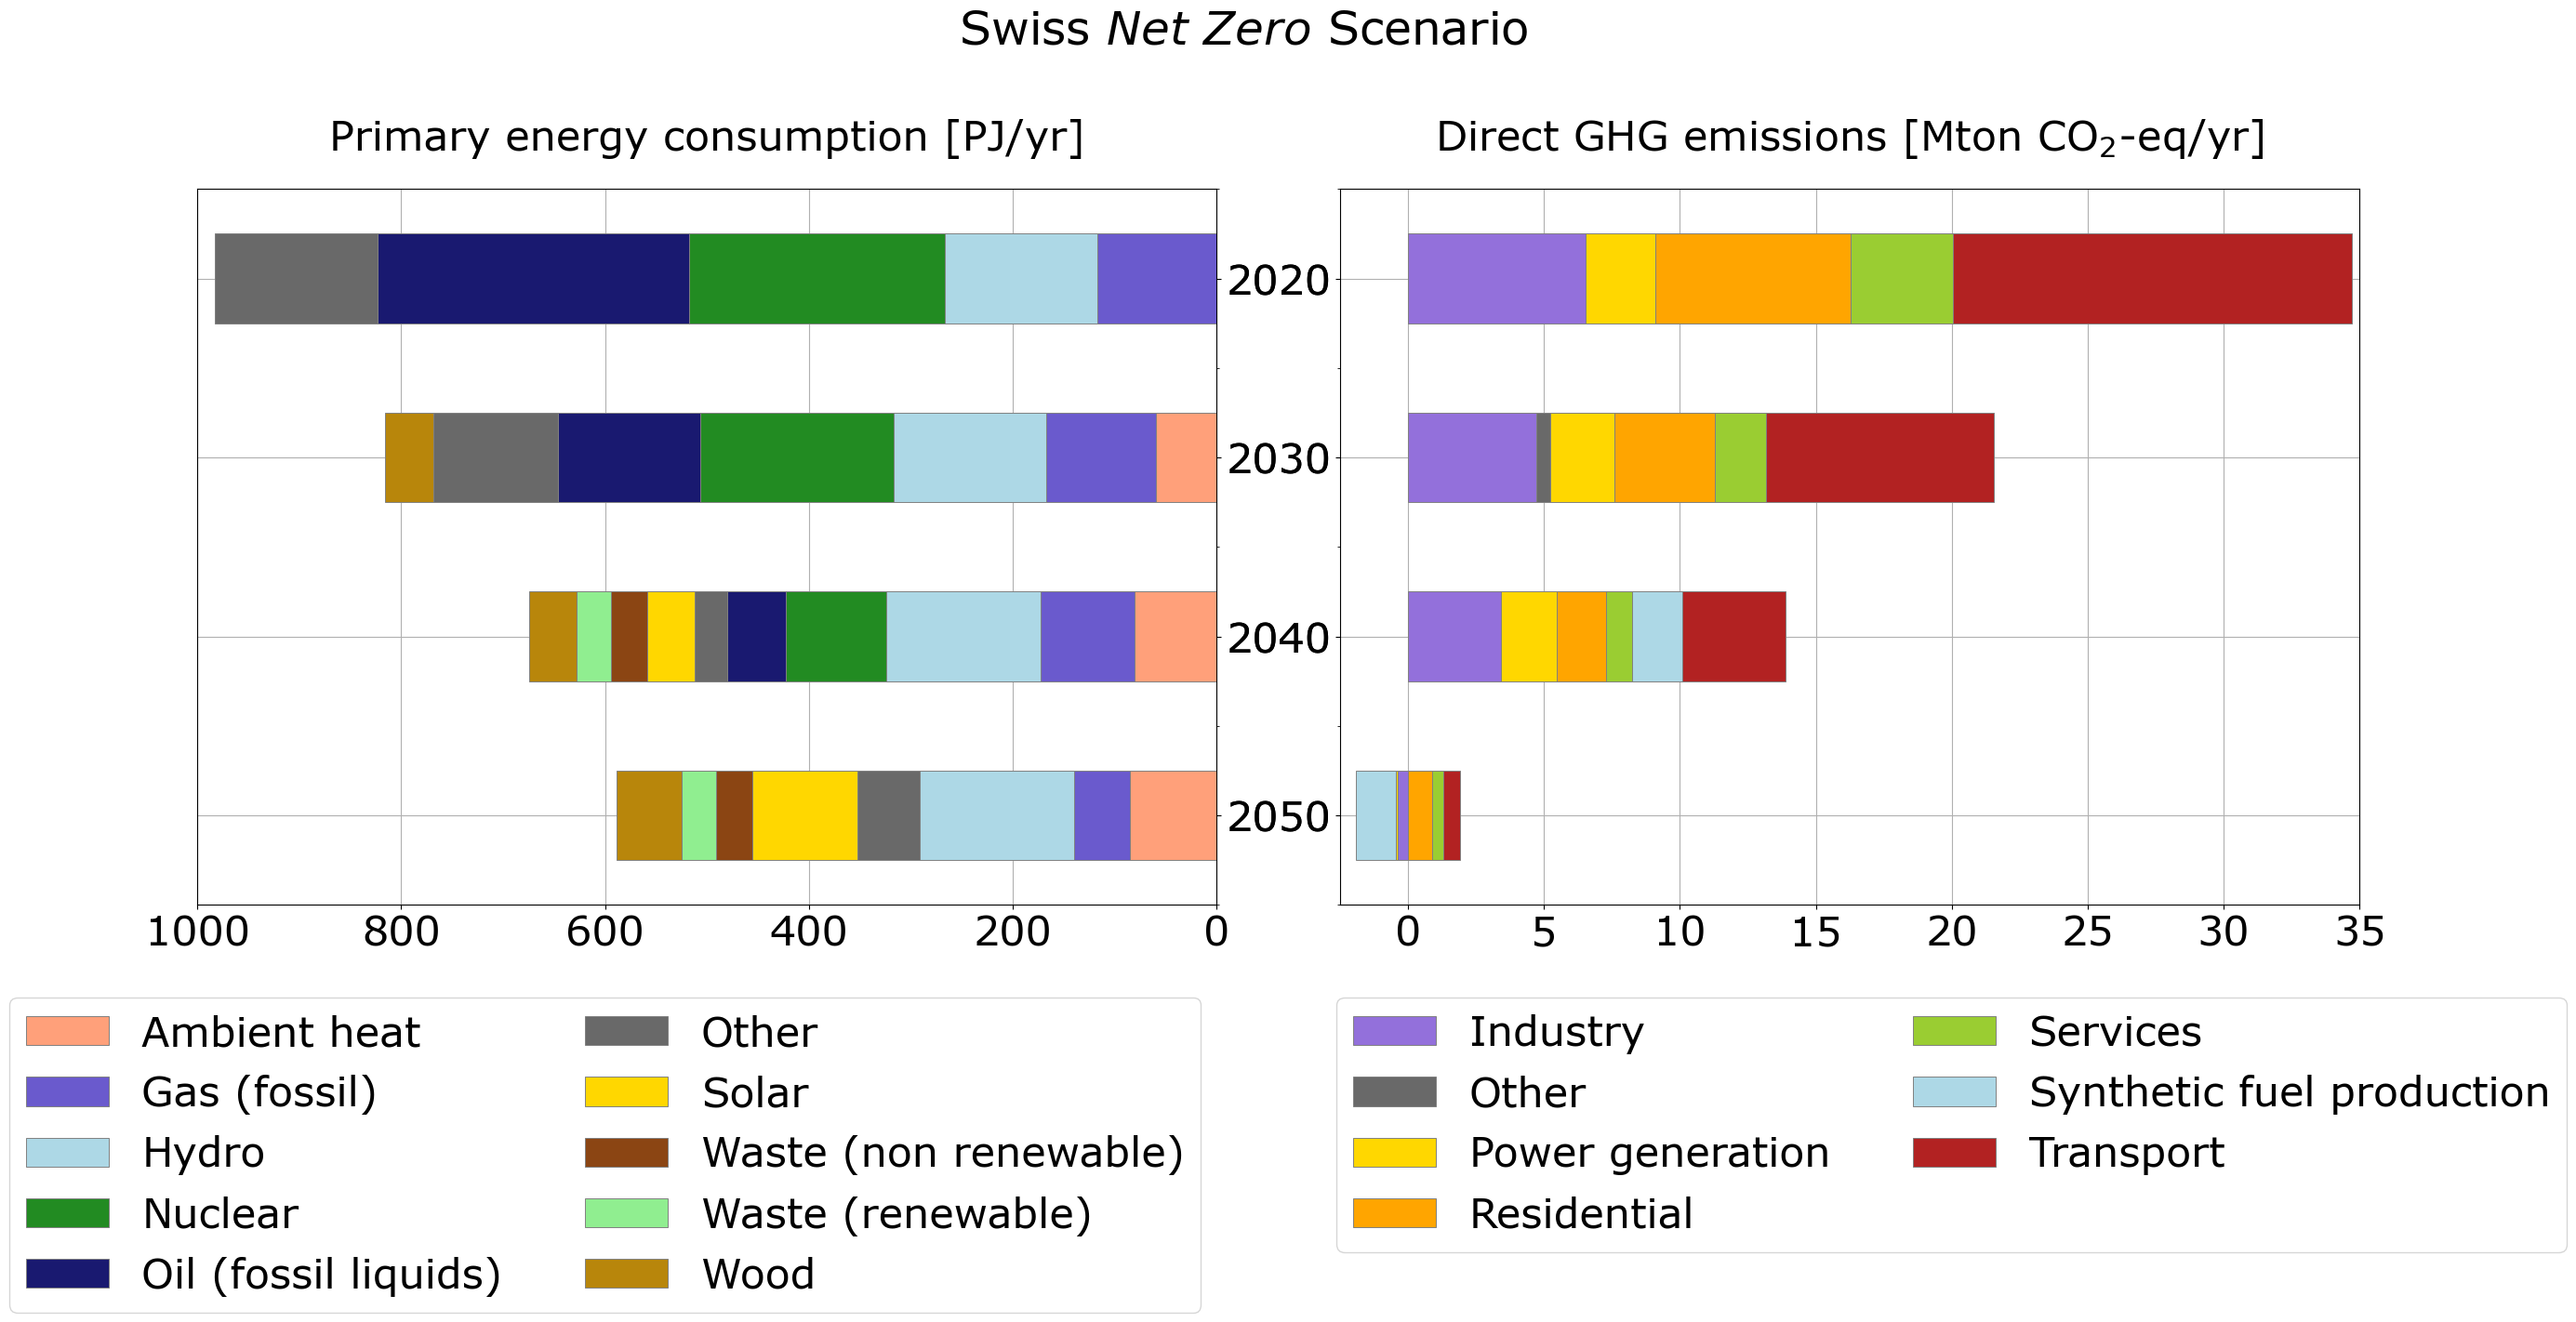

In [16]:
# Set up the figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(30, 10), gridspec_kw={'wspace': 0.121})

# Plot the SPS1 data
plot_with_consistent_colors(df_sources_pivot_sps1_filtered, axs[0], 'Primary energy consumption [PJ/yr]', (1000, 0), sector_colors_sources)
axs[0].invert_yaxis()
axs[0].set_ylabel('')


plot_with_consistent_colors(df_emissions_pivot_sps1_filtered, axs[1], 'Direct GHG emissions [Mton CO$_2$-eq/yr]', (-2.5, 35), sector_colors_emissions)
axs[1].invert_yaxis()
axs[1].set_ylabel('')
axs[1].tick_params(right=False, labelright=False)  # Hide y-ticks and labels for the right plot

# Add legends under the lower plots
axs[0].legend(loc='upper center', bbox_to_anchor=(0.4, -0.1), fontsize=32, ncol=2)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.6, -0.1), fontsize=32, ncol=2)

# Hide y-ticks and labels for the left plots
axs[0].tick_params(left=False, labelleft=False)  # Upper left plot

# Ensure y-ticks and labels for the right plots are visible
axs[1].tick_params(left=True, labelleft=True, right=False, labelright=False)  # Upper right plot

# Adjust y-ticks to be centered between the plots
axs[0].yaxis.set_ticks_position('right')
axs[1].yaxis.set_ticks_position('left')

fig.text(0.5, 1.05, "Swiss $\it{Net\ Zero}$ Scenario", ha='center', va='center', fontsize=36)

plt.savefig('Figure 1_scenario_results.png', dpi=300, bbox_inches='tight')

plt.show()